# FCNN (Fully Convolutional Neural Network)

Este tipo de arquitecturas son conformadas por dos bloques principales, que conforman una trayectoria de codificador-decodificador o una trayectoria expansiva de contracción equivalente. En la figura se observan estas dos etapas y se muestra un ejemplo de cómo las características extraídas se hacen más particulares o especificas a medida que se profundiza en la red.

Los codificadores-decodificadores pueden definirse así:

* **Codificador (parte izquierda de la red)**: Codifica la imagen en una representación abstracta de las características de la imagen aplicando una secuencia de bloques convolucionales que disminuyen gradualmente la altura y la anchura de la representación, pero un número creciente de canales que corresponden a las características de la imagen.

* **Decodificador (parte derecha de la red)**: Decodifica la representación de la imagen en una máscara binaria aplicando una secuencia de convoluciones ascendentes (NO es lo mismo que la deconvolución) que aumenta gradualmente la altura y la anchura de la representación hasta el tamaño de la imagen original y disminuye el número de canales hasta el número de clases que estamos segmentando.

    
<div style="width:100%;text-align: center;">
<img src="https://i.imgur.com/WNCNVHS.png" width="800" height="400"/>
</div>

La FCNN es la arquitectura más utilizada para la segmentación de imágenes, entre ellas, se utiliza una en particular para imagenes médicas y se conoce como red U-net la cual tiene conexiones entre los dos bloques principales con el fin de aportar información a la etapa de reconstrucción del mapa de características.

# Objetivo de las redes U-Net
U-Net es una arquitectura de red convolucional para la segmentación rápida y precisa de imágenes. La intención de U-Net es captar tanto las características del contexto como las de la ubicación. La idea principal de la aplicación es utilizar capas de contracción sucesivas, a las que siguen inmediatamente operadores de remuestreo para obtener salidas de mayor resolución en las imágenes de entrada.
# Arquitectura UNET
  

<div>
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="900" height="800"/>
</div>


Al visualizar la forma de la arquitectura de la red, podemos ver por qué probablemente se llama U-Net. La arquitectura tiene forma de U, de ahí su nombre. La arquitectura de la red se ilustra en la figura anterior. Consta de una vía de contracción (lado izquierdo) y una vía de expansión (lado derecho) al igual que las FCNN y además contiene la conexión entre los dos bloques como se mencionó anteriormente. La ruta de contracción sigue la arquitectura típica de una red convolucional (CNN).

# Database para aplicar modelo U-net
La base de datos utilizada consiste en 800 imágenes de radiografía de tórax donde 394 imágenes corresponden a una manifestación de tuberculosis y 406 corresponden a radigrafías normales o de personas sanas. Esta base de datos es una combinación de dos bases de datos conocidas en el estado del arte para radiografía de tórax (Montgomery y Shenzen database).

## Etapas de pre-procesamiento y entrenamiento
1. Cargar la base de datos
2. Preparación de los datos
3. Imágenes de entrenamiento y de prueba
4. Construyendo una red U-net
5. Entrenamiento del modelo U-net
6. Métricas y validacón

# Configuración

In [1]:
!pip install opencv-python pandas numpy tensorflow==2.15.1 seaborn tqdm scikit-image pennylane pennylane-lightning-gpu scikit-learn custatevec_cu12 torch --quiet

In [2]:
!python --version

Python 3.10.12


In [3]:
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf

from PIL import Image # Librería de edición de imágenes
from tqdm import tqdm # librería para monitorear las funciones y sus tiempos de ejecución.
import cv2 # Librería Open-CV para python.

from skimage import segmentation
from glob import glob
from collections import defaultdict # Define un diccionario
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set(font_scale = 2)

from ipywidgets import interact

In [4]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check for available GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
    print("GPU Details: ", gpus)
else:
    print("No GPU available.")


TensorFlow version: 2.15.1
Num GPUs Available:  1
GPU Details:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Cargar la base de datos

Sobre los datos:
* Hay una pequeña anormalidad en la convención de nombres de las máscaras.
* Algunas imágenes no tienen sus correspondientes máscaras.

Comprobación de las radiografías y sus respectivas máscaras

In [5]:
# !unzip data.zip -d chest-xray-data/

In [6]:
# Declarando los directorios de las imágenes
DIR = "./chest-xray-data/data/"

lung_image_paths = glob(os.path.join(DIR,"Lung Segmentation/CXR_png/*.png")) # Directorio de las imagenes radiográficas.
mask_image_paths = glob(os.path.join(DIR,"Lung Segmentation/masks/*.png")) # Directorio de las máscaras, que indican la localización de pulmones.

related_paths = defaultdict(list)

# Combinando las imágenes de 1 para 1
for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)

paths_df = pd.DataFrame.from_dict(related_paths)
paths_df.head()

""


In [7]:
paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [ ]:
Nimgs = paths_df.shape[0] # Número total de imagenes
print("Número total de imagenes", Nimgs)
@interact(xray_num = (0,Nimgs-1,1))
def plot_pair_img_mask(xray_num):
    img_path = paths_df["image_path"][xray_num]
    mask_path = paths_df["mask_path"][xray_num]

    img = Image.open(img_path)
    mask = Image.open(mask_path)

 ## Visualizar imagen e independientemente su máscara
    fig = plt.figure(figsize = (10,10))

    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(img, cmap = "gray")
    plt.title("Original")
    plt.axis('off')

    ax2 = fig.add_subplot(2,2,2)
    plt.axis('off')
    ax2.imshow(mask, cmap = "viridis")
    plt.title("Máscara real")
    fig.show()

    plt.figure(figsize = (5,5))
    plt.imshow(img, cmap = "gray")
    edges_est = segmentation.clear_border(np.squeeze(mask))
    plt.contour(edges_est,[0.5],colors=['red'])
    plt.axis('off')
    plt.show()

## 2. Preparación de los datos  
En este paso crearemos una función para tratar las imágenes de rayos X y las máscaras. Este proceso es necesario para poder preprocesar y normalizar las imágenes.  
Utilizaremos la biblioteca `cv2` para redimensionar las imágenes y las máscaras.

In [ ]:
img_side_size = 256 # tamaño de las imágenes a procesar.

def prepare_train_test(df = pd.DataFrame(), resize_shape = tuple(), color_mode = "gray"):
    img_array = list()
    mask_array = list()

    # Preparando Imagenes
    for image_path in tqdm(paths_df.image_path):
        resized_image = cv2.resize(cv2.imread(image_path),resize_shape) # Reescalando las imagenes a una resolución dada por el parámetro resize_shape
        resized_image = resized_image/255. # Normalizamos las intensidades de la imágen a valores entre 0 y 1.
        # Procesar según el tipo de imagen (Color --> RGB | escala de grises --> Gray)
        if color_mode == "gray":
            img_array.append(resized_image[:,:,0])
        elif color_mode == "rgb":
            img_array.append(resized_image[:,:,:])

    # Preparando las mascaras
    for mask_path in tqdm(paths_df.mask_path):
        resized_mask = cv2.resize(cv2.imread(mask_path),resize_shape)
        resized_mask = resized_mask/255.
        mask_array.append(resized_mask[:,:,0])

    return img_array, mask_array

img_array, mask_array = prepare_train_test(df = paths_df, resize_shape = (img_side_size,img_side_size), color_mode = "gray")

####Separación de los datos de entrenamiento y de prueba clásicos

In [ ]:
from sklearn.model_selection import train_test_split # Función para separar el conjunto de entrenamiento y de test.
img_train, img_test, mask_train, mask_test = train_test_split(img_array, mask_array, test_size = 0.2, random_state= 42)

# Se realiza un reshape para asegurar la forma del tensor adecuada: #img x W x H x C | donde W es el ancho de las imagenes, H es el alto y C el número de canales (gray C=1, RGB C=3)

img_train = np.array(img_train).reshape(len(img_train), img_side_size, img_side_size, 1)
img_test = np.array(img_test).reshape(len(img_test), img_side_size, img_side_size, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), img_side_size, img_side_size, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), img_side_size, img_side_size, 1)

## 3. Quantum *part*

#### Circuit with pennylane

In [ ]:
import pennylane as qml

# dev = qml.device('qiskit.aer', wires=4, backend='aer_simulator_extended_stabilizer', ibmqx_token=IBM_TOKEN , shots=1) # OK
# dev = qml.device('qiskit.aer', wires=4, backend='aer_simulator_matrix_product_state', ibmqx_token=IBM_TOKEN , shots=1) # OK
dev = qml.device('default.qubit', wires=4, shots=1024) # OK
# dev = qml.device("lightning.gpu", wires=4) # OK


# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(1, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
    # Random quantum circuit
    qml.RandomLayers(rand_params, wires=list(range(4)))
    # print("*** Measuring...")
    # Measurement producing 4 classical output values
    output = [qml.expval(qml.PauliZ(j)) for j in range(4)]
    # print("*** Output:", output)
    return output


In [ ]:
def quanv(image):
    w = 256
    h = 256
    channels = 1 # B/N
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((w, h, channels))
    q_results = [0]
    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, w, 2):
        for k in range(0, h, 2):
            # Process a squared 2x2 region of the image with a quantum circuit

                q_results = circuit(
                    [
                        image[j, k, 0],
                        image[j, k + 1, 0],
                        image[j + 1, k, 0],
                        image[j + 1, k + 1, 0]
                    ]
                )
                # Assign expectation values to different channels of the output pixel (j, k)
                for c in range(channels):
                    out[j, k, c] = q_results[c]
    return out

#### Load or Preprocessing classical data

In [9]:
import numpy as np
import os
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

PREPROCESS = True

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def preprocess_image(img, idx):
    """Preprocess a single image using quantum processing."""
    try:
        logging.info(f"Processing Image: {idx + 1}")
        return quanv(img)
    except Exception as e:
        logging.error(f"Image {idx}: Unexpected error - {e}")
    return None  # Return None if processing fails

def preprocess_images(images):
    """Preprocess a batch of images using threading for efficiency."""
    q_images = []
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(preprocess_image, img, idx): idx for idx, img in enumerate(images)}
        for future in as_completed(futures):
            result = future.result()
            if result is not None:  # Only append if processing was successful
                q_images.append(result)

    return np.asarray(q_images)

def save_or_load(filename, data_func):
    """Save data to a file or load it if already exists."""
    if os.path.exists(filename):
        logging.info(f"Loading {filename}")
        return np.load(filename)
    else:
        data = data_func()
        np.save(filename, data)
        logging.info(f"Saved {filename}")
        return data

if PREPROCESS:
    q_train_images = save_or_load("q_train_images.npy", lambda: preprocess_images(img_train))
    q_test_images = save_or_load("q_test_images.npy", lambda: preprocess_images(img_test))
    q_train_masks = save_or_load("q_train_masks.npy", lambda: preprocess_images(mask_train))
    q_test_masks = save_or_load("q_test_masks.npy", lambda: preprocess_images(mask_test))

q_train_masks = (q_train_masks > 0).astype(np.float32)
q_test_masks = (q_test_masks > 0).astype(np.float32)


#### Results

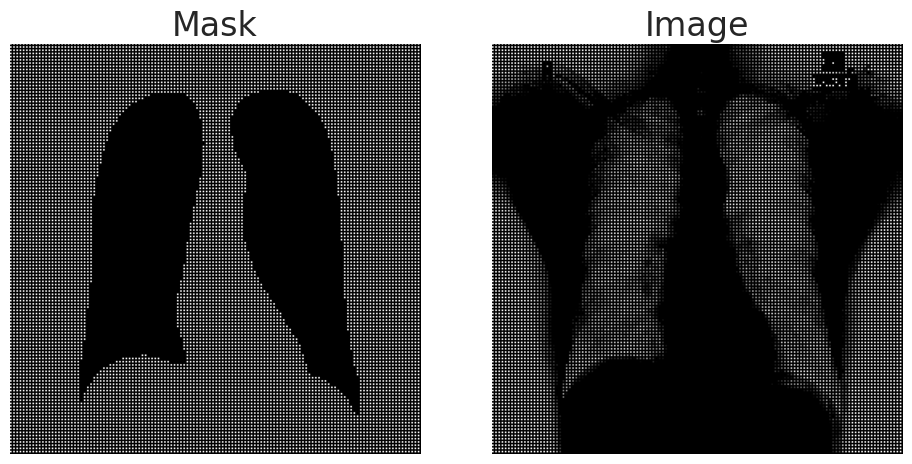

In [10]:
# Example input array for mask (replace with your actual array)
arr_mask = q_train_masks[0]

# Process the mask image
# 1. Clip the values to the range [0, 1]
arr_mask = np.clip(arr_mask, 0, 1)

# 2. Scale the values to the range [0, 255]
arr_mask = (arr_mask * 255).astype(np.uint8)

# 3. Remove the single channel dimension if necessary
arr_mask = np.squeeze(arr_mask)

# 4. Convert to a PIL image
mask_img = Image.fromarray(arr_mask)

# Optional: Save the mask image as PNG
mask_img.save("training_mask_image.png")

# Example input array for image (replace with your actual array)
arr_image = q_train_images[2]

# Process the image
# 1. Clip the values to the range [0, 1]
arr_image = np.clip(arr_image, 0, 1)

# 2. Scale the values to the range [0, 255]
arr_image = (arr_image * 255).astype(np.uint8)

# 3. Remove the single channel dimension if necessary
arr_image = np.squeeze(arr_image)

# 4. Convert to a PIL image
image_img = Image.fromarray(arr_image)

# Optional: Save the image as PNG
image_img.save("training_image.png")

# Create a figure to plot both images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the mask image
axs[0].imshow(mask_img, cmap="gray")
axs[0].set_title("Mask")
axs[0].axis('off')

# Plot the main image
axs[1].imshow(image_img, cmap="gray")
axs[1].set_title("Image")
axs[1].axis('off')

# Show the plot
plt.tight_layout()
plt.show()


## 4. Construyendo una red U-net

* Las métricas utilizadas para evaluar los resultados son el coeficiente Dice e IoU (Intersection over Union):

<div style="width:100%;text-align: center;">
<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="500" height="300"/>
</div>

<div style="width:100%;text-align: center;">
<img src="https://i.imgur.com/yJp0n0n.png" width="500" height="300"/>
</div>

In [11]:
# Función que calcula la medida Dice
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Función que calcula la pérdida según el Dice.
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Función Dice para test
def dice_coef_test(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)
    if union==0: return 1
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

# Intersection over Union metric
def IOU(y_true,y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    sum_ = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred)
    jac = (intersection + 1) / (sum_ - intersection + 1)
    return jac

### Arquitectura U-net

In [12]:
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     concatenate, Dropout)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

img_side_size = 256  # Image size to be processed.

def unet(input_size=(img_side_size, img_side_size, 1)):
    inputs = Input(input_size)

    # Encoder (Left side of the "U")
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    drop1 = Dropout(0.1)(conv1)  # Dropout after first block
    pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    drop2 = Dropout(0.1)(conv2)  # Dropout after second block
    pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    drop3 = Dropout(0.2)(conv3)  # Higher dropout as the network deepens
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.3)(conv5)  # Higher dropout to regularize deep layers

    # Decoder (Right side of the "U")
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(drop5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    drop9 = Dropout(0.1)(conv9)  # Final dropout to regularize the output

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(drop9)

    return Model(inputs=[inputs], outputs=[conv10])


In [13]:
model = unet(input_size=(img_side_size,img_side_size,1)) # Creamos el modelo

In [14]:
model.compile( # Opciones de compilación
    optimizer=Adam(learning_rate=1e-4, clipnorm=1.0),
    loss="binary_crossentropy",
    metrics=[dice_coef_loss, 'binary_accuracy']
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 32)         0         ['conv2d_1[0][0]']            
                                                                                              

## 5. Entrenamiento del modelo U-Net

Para nuestro entrenamiento utilizaremos `epochs = 30`, que es el número de veces que recorreremos el conjunto de lotes de entrenamiento.

In [17]:
params = {
    "epoch_nr": 30,
    "batch_size": 32,
}

# Callback, si después de 3 epocas, la pérdida no se reduce o cambia. Se para el entrenamiento de forma temprana.
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=3
)

nan_callback = tf.keras.callbacks.TerminateOnNaN()

history = model.fit(
    x = q_train_images,
    y = q_train_masks,
    validation_data = (q_test_images, q_test_masks),
    epochs= params["epoch_nr"],
    batch_size= params["batch_size"],
    callbacks=[earlystopping, nan_callback]
)


Epoch 1/30
18/18 [==============================] - 69s 2s/step - loss: 0.6602 - dice_coef_loss: 0.7267 - binary_accuracy: 0.8058 - val_loss: 0.5978 - val_dice_coef_loss: 0.7085 - val_binary_accuracy: 0.8146
Epoch 2/30
18/18 [==============================] - 14s 807ms/step - loss: 0.2989 - dice_coef_loss: 0.4243 - binary_accuracy: 0.9071 - val_loss: 0.1785 - val_dice_coef_loss: 0.3868 - val_binary_accuracy: 0.9292
Epoch 3/30
18/18 [==============================] - 14s 801ms/step - loss: 0.1582 - dice_coef_loss: 0.2736 - binary_accuracy: 0.9282 - val_loss: 0.1549 - val_dice_coef_loss: 0.2967 - val_binary_accuracy: 0.9363
Epoch 4/30
18/18 [==============================] - 14s 763ms/step - loss: 0.1445 - dice_coef_loss: 0.2469 - binary_accuracy: 0.9336 - val_loss: 0.1390 - val_dice_coef_loss: 0.2693 - val_binary_accuracy: 0.9382
Epoch 5/30
18/18 [==============================] - 14s 760ms/step - loss: 0.1208 - dice_coef_loss: 0.2018 - binary_accuracy: 0.9357 - val_loss: 0.1081 - val_d

## Guardado del modelo

Modelo

In [18]:
model.save('./hybrid_model_30_epochs_GPU_256x256_4_qubit_default.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Pesos/weights

In [19]:
model.save_weights('model_weights.h5')

### Visualización del resultado
Aquí crearemos una función para visualizar la imagen de vista previa, la imagen de la máscara real, la superposición sobre la máscara real y la imagen original.

In [20]:
# Ensure mask_test and predictions are cast to float32 for TensorFlow compatibility.
mask_test = tf.cast(q_test_masks, tf.float32)

Nimgs = len(q_test_images)  # Número total de imágenes
img_array = q_test_images

@interact(img_num=(0, Nimgs - 1, 1))
def test_on_image(img_num):
    """Visualiza predicciones y métricas para imágenes de prueba."""

    # Model prediction and reshaping
    pred = model.predict(img_array[img_num].reshape(1, img_side_size, img_side_size, 1))
    pred = tf.cast(pred, tf.float32)  # Ensure pred is float32
    pred = tf.where(pred > 0.5, 1.0, 0.0)  # Binarize predictions

    # Calculate Dice and IOU
    dice = dice_coef_test(y_true=mask_test[img_num], y_pred=pred)
    iou = IOU(y_true=mask_test[img_num], y_pred=pred)

    # Create a figure to display results
    fig = plt.figure(figsize=(15, 10))

    # Display Prediction
    plt.subplot(1, 3, 1)
    plt.imshow(pred.numpy().reshape(img_side_size, img_side_size), cmap="PuBu")
    plt.title("Predicción")
    plt.axis("off")

    # Display Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask_test[img_num].numpy().reshape(img_side_size, img_side_size), cmap="viridis")
    plt.title("Máscara real")
    plt.axis("off")

    # Display Image with Contours
    plt.subplot(1, 3, 3)
    plt.imshow(img_array[img_num].reshape(img_side_size, img_side_size), cmap="gray")
    edges_est1 = segmentation.clear_border(
        np.squeeze(mask_test[img_num].numpy().reshape(img_side_size, img_side_size))
    )
    edges_est2 = segmentation.clear_border(
        np.squeeze(pred.numpy().reshape(img_side_size, img_side_size))
    )
    plt.contour(edges_est1, [0.5], colors=['red'])
    plt.contour(edges_est2, [0.5], colors=['blue'])
    plt.title('Superposición')
    plt.axis('off')

    # Display metrics and save the result
    plt.suptitle(f'Dice: {dice:.2%} and IOU: {iou:.2%}', fontsize=28)
    plt.savefig('prediction.png',
                bbox_inches='tight', pad_inches=1, facecolor='white')
    plt.show()

    return None

interactive(children=(IntSlider(value=70, description='img_num', max=140), Output()), _dom_classes=('widget-in…

## 6. Métricas y validación  
+ **Cross-entropy (pérdida)**: para cuantificar la diferencia entre las dos distribuciones de probabilidad (entrenamiento y validación).
* **Coeficiente Dice**: El coeficiente de Dice es un estadístico utilizado para medir la similitud de dos muestras, una de las métricas más utilizadas en el contexto de la segmentación de imágenes.

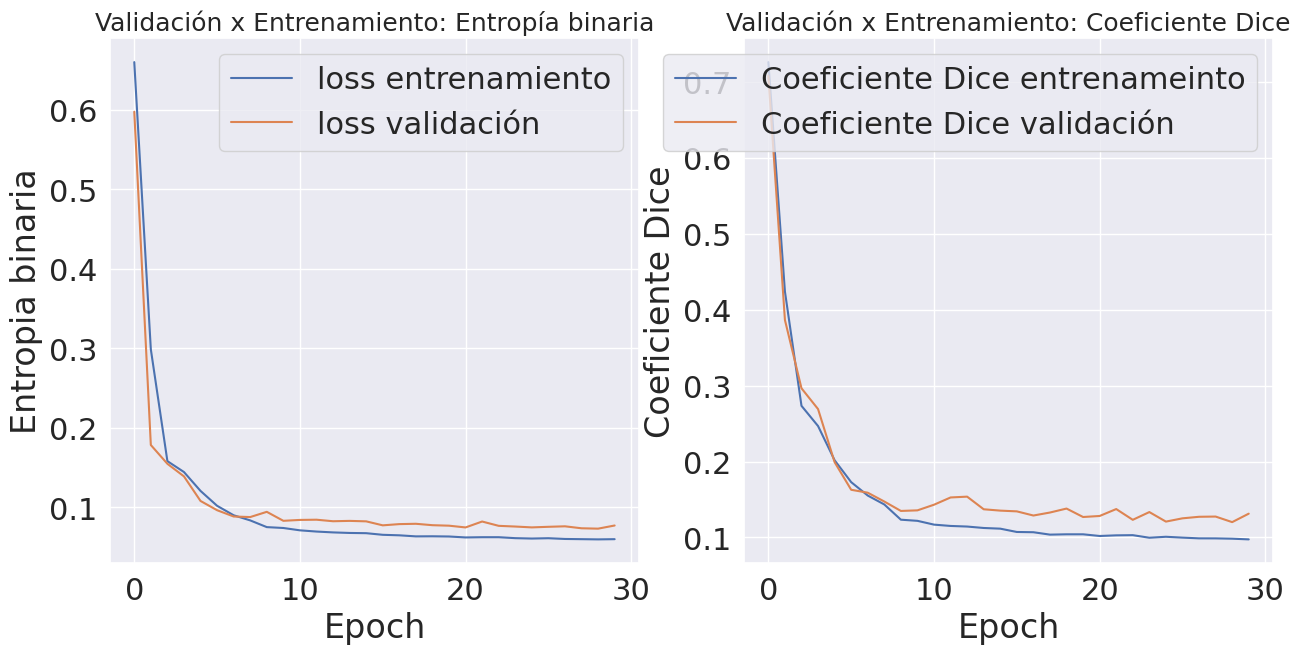

In [21]:
def get_metrics(history):
    fig = plt.figure(figsize = (15,15))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "loss entrenamiento")
    plt.plot(history.history["val_loss"], label = "loss validación")
    plt.title("Validación x Entrenamiento: Entropía binaria", fontsize=18, y=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Entropia binaria")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef_loss"], label = "Coeficiente Dice entrenameinto")
    plt.plot(history.history["val_dice_coef_loss"], label = "Coeficiente Dice validación")
    plt.title("Validación x Entrenamiento: Coeficiente Dice", fontsize=18, y=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Coeficiente Dice")
    plt.savefig('metrics.png', bbox_inches='tight', pad_inches=1, facecolor='white')


get_metrics(history = history)

### Comprobación de la validación de la prueba mediante el coeficiente Dice  
Utilizaremos los datos de la prueba para hacer nuestra predicción y realizaremos el solapamiento entre la máscara predicha y la real.

In [22]:
# Ensure masks are float32 for compatibility
q_test_masks = tf.cast(q_test_masks, tf.float32)

dice_coefs = list()

# Predict all images at once
pred = model.predict(q_test_images)

# Binarize predictions
pred = tf.cast(pred >= 0.5, tf.float32)

# Iterate over predictions and calculate Dice coefficients
for i in tqdm(range(len(q_test_images))):
    prediction = pred[i]
    mask = q_test_masks[i]

    # Ensure prediction and mask are float32
    prediction = tf.cast(prediction, tf.float32)
    mask = tf.cast(mask, tf.float32)

    # Calculate Dice coefficient
    dice = dice_coef_test(y_true=mask, y_pred=prediction)
    dice_coefs.append(dice)

5/5 [==============================] - 1s 155ms/step


100%|██████████| 141/141 [00:00<00:00, 471.15it/s]


Mediana Coef. Dice: 0.9203304052352905


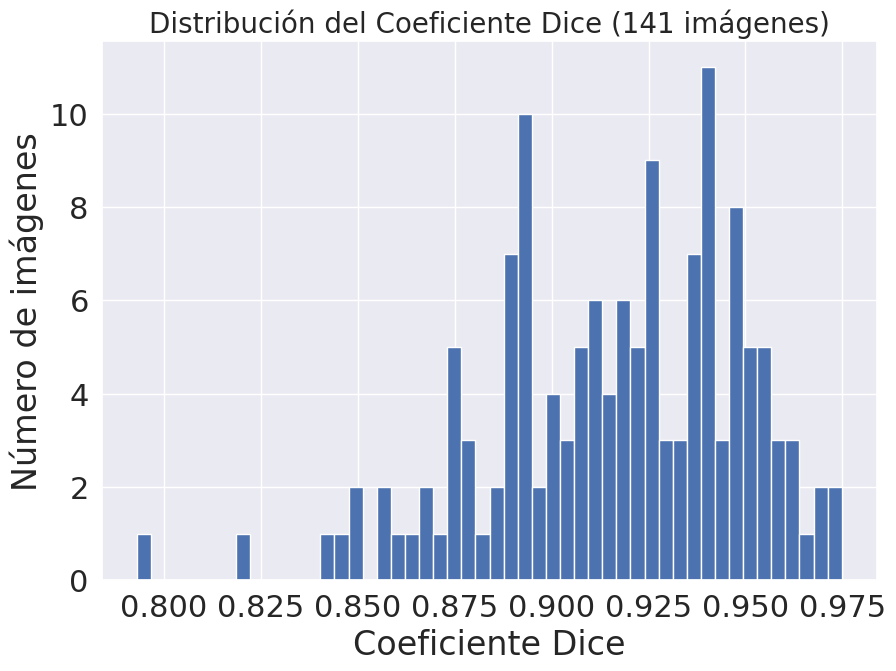

In [23]:
fig, ax = plt.subplots(figsize =(10, 7))
plt.hist(np.array(dice_coefs), bins = 50)
plt.title("Distribución del Coeficiente Dice (141 imágenes)",fontsize=20, y=1)
plt.xlabel("Coeficiente Dice")
plt.ylabel("Número de imágenes")
print(f'Mediana Coef. Dice: {np.median(np.array(dice_coefs))}')
plt.show()

Mediana Coef. Dice: 0.9203304052352905


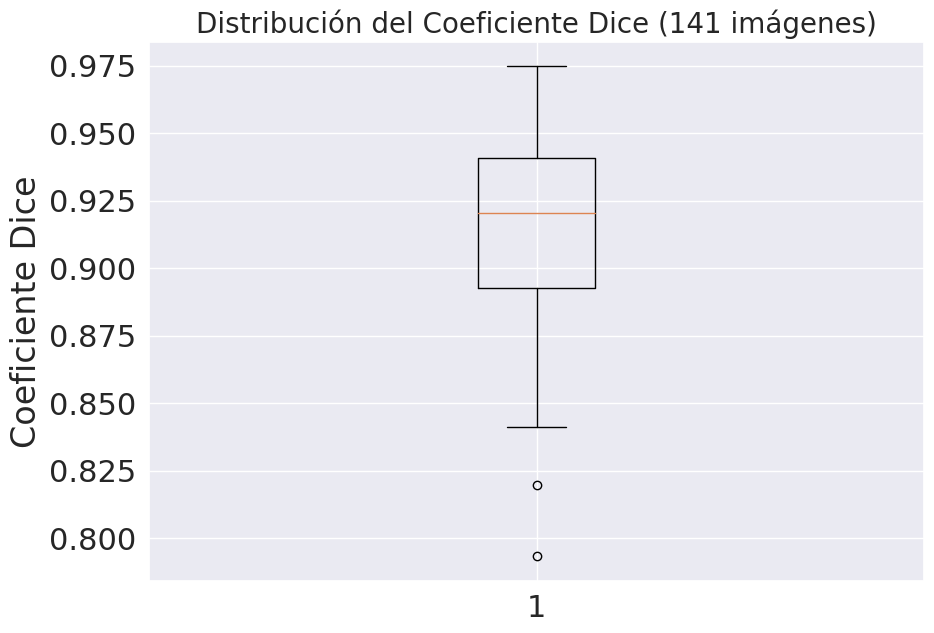

In [24]:
fig, ax = plt.subplots(figsize =(10, 7))
plt.boxplot(np.array(dice_coefs))
plt.title("Distribución del Coeficiente Dice (141 imágenes)",fontsize=20, y=1)
plt.ylabel("Coeficiente Dice")
print(f'Mediana Coef. Dice: {np.median(np.array(dice_coefs))}')
plt.show()

# Load pre-trained model

In [25]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tqdm import tqdm # librería para monitorear las funciones y sus tiempos de ejecución.
import cv2 # Librería Open-CV para python.
from skimage import segmentation
import numpy as np
import tensorflow.keras.backend as K

In [26]:

def load_trained_model():
    try:
        K.set_floatx('float64')
        custom_objects = {'dice_coef_loss': {}}
        model_path = './hybrid_model_30_epochs_GPU_256x256_4_qubit_default.h5'
        model = load_model(model_path, custom_objects=custom_objects)
        print('Model loaded OK')
        return model

    except Exception as e:
        return {"error": "No se puede cargar el modelo: " + str(e)}


In [27]:
load_trained_model()

Model loaded OK


In [28]:
# Definir la función de predicción
def predict_image():
    # Cargar el modelo entrenado
    model = load_trained_model()
    if isinstance(model, dict):
        return model

    # Procesar la imagen
    img_side_size = 256
    img_path = './xr-lung-segmentation.jpeg'
    img = cv2.imread(img_path)
    if img is None:
        return {"error": f"No se pudo cargar la imagen: {img_path}"}
    img = cv2.resize(img, (img_side_size, img_side_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_array = np.array(img, dtype=np.float32) / 255.0  # Normalizar la imagen

    # Verificar que la imagen tenga el tamaño correcto
    input_shape = model.input_shape[1:3]
    if img.shape[:2] != input_shape:
        return {"error": f"El tamaño de la imagen no coincide con el tamaño de entrada del modelo: {img.shape} vs {input_shape}"}

    # Realizar la predicción
    pred = model.predict(img_array.reshape(1,img_side_size,img_side_size,1))
    pred[pred>0.5] = 1.0
    pred[pred<0.5] = 0.0

    # Crear la figura de matplotlib
    fig = plt.figure(figsize=(15, 10))

    plt.subplot(1,3,1)
    plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "viridis")
    plt.title("Prediction")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(img.reshape(img_side_size, img_side_size), cmap='gray')
    edges_est = segmentation.clear_border(np.squeeze(pred.reshape(img_side_size, img_side_size)))
    plt.contour(edges_est,[0.5],colors=['blue'])
    plt.title('Original Image')
    plt.axis('off')

    plt.savefig('./results.png', bbox_inches='tight', pad_inches=0)

    # Devolver los resultados
    return {"plot": fig}

In [29]:
def predict():
    results = []

    # Manejar errores si no se puede procesar la imagen
    try:
        result = predict_image()
    except Exception as e:
        return {"error": "No se puede procesar la imagen: " + str(e)}

    results.append(result)

    return {"results": results}

Model loaded OK
1/1 [==============================] - 0s 243ms/step


{'results': [{'plot': <Figure size 1500x1000 with 2 Axes>}]}

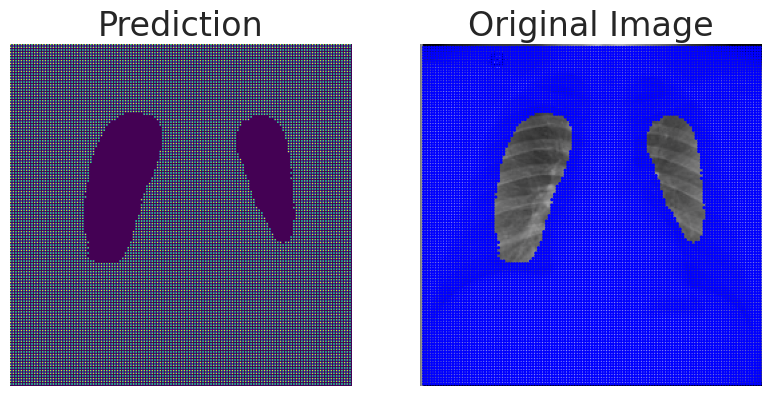

In [30]:
predict()